##***What's Cooking***

**Problem Definition**

Predict the category of a dish's cuisine given a list of its ingredients. 

## **Adding our libraries**

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style
import plotly.graph_objs as plotly  # for interactive plots
import string
import random
import tensorflow as tf
from tensorflow import keras
from keras import metrics
from keras.utils import to_categorical
from collections import Counter
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import json

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


**Loading the data**

In [3]:
from google.colab import files

# Get a list of the csv files that have been uploaded into your colab
# environment.
json_uploaded = !ls *.json

# If the metadata file is not already in the colab enviroment, load it
if ('train.json' not in json_uploaded):
  uploaded = files.upload()

Saving train.json to train (1).json


In [4]:
if ('test.json' not in json_uploaded):
  uploaded = files.upload()

Saving test.json to test (1).json


In [62]:
test_data = pd.read_json('test.json')

train_data = pd.read_json('train.json')
print("Test Data: ")
display(test_data)
print()
print("Train Data: ")
display(train_data)

Test Data: 


,id,ingredients
0,18009,"[baking powder, eggs, all-purpose flour, raisi..."
1,28583,"[sugar, egg yolks, corn starch, cream of tarta..."
2,41580,"[sausage links, fennel bulb, fronds, olive oil..."
3,29752,"[meat cuts, file powder, smoked sausage, okra,..."
4,35687,"[ground black pepper, salt, sausage casings, l..."
...,...,...
9939,30246,"[large egg yolks, fresh lemon juice, sugar, bo..."
9940,36028,"[hot sauce, butter, sweet potatoes, adobo sauc..."
9941,22339,"[black pepper, salt, parmigiano reggiano chees..."
9942,42525,"[cheddar cheese, cayenne, paprika, plum tomato..."



Train Data: 


,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."
...,...,...,...
39769,29109,irish,"[light brown sugar, granulated sugar, butter, ..."
39770,11462,italian,"[KRAFT Zesty Italian Dressing, purple onion, b..."
39771,2238,irish,"[eggs, citrus fruit, raisins, sourdough starte..."
39772,41882,chinese,"[boneless chicken skinless thigh, minced garli..."


For the test data we are givin a list of ids and the corresponding ingredients for that id.

For the train data we are givin the id, their cuisines, and the cuisines ingredients. 

## **Analysis**

Printing the shapes of the train data and the test data

In [6]:
print("Train data shape: ", train_data.shape)
print("Test data shape: ", test_data.shape)
print()
print("Train Data")
print(train_data.head())
print()
print("Test Data")
print(test_data.head())

Train data shape:  (39774, 3)
Test data shape:  (9944, 2)

Train Data
      id      cuisine                                        ingredients
0  10259        greek  [romaine lettuce, black olives, grape tomatoes...
1  25693  southern_us  [plain flour, ground pepper, salt, tomatoes, g...
2  20130     filipino  [eggs, pepper, salt, mayonaise, cooking oil, g...
3  22213       indian                [water, vegetable oil, wheat, salt]
4  13162       indian  [black pepper, shallots, cornflour, cayenne pe...

Test Data
      id                                        ingredients
0  18009  [baking powder, eggs, all-purpose flour, raisi...
1  28583  [sugar, egg yolks, corn starch, cream of tarta...
2  41580  [sausage links, fennel bulb, fronds, olive oil...
3  29752  [meat cuts, file powder, smoked sausage, okra,...
4  35687  [ground black pepper, salt, sausage casings, l...


I will create a graph so I can visually see which cuisine appears the most in 
the data set.

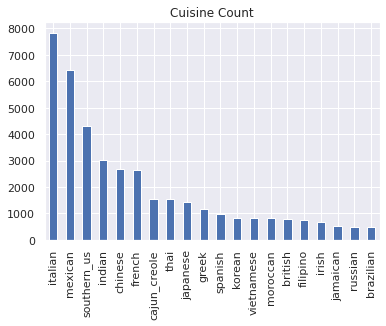

In [7]:
cuisine_list = train_data['cuisine']
train_data['cuisine'].value_counts().plot(kind='bar', title = 'Cuisine Count')

It would be interesting to see the most popular ingredients for each
cuisine to help better understand the data.

First we'll need to count the occurence of each ingredient in each cuisine. 

In [0]:
ingredent_dict = {}
for cuisine in train_data['cuisine'].unique():
  ingredent_dict[cuisine] = Counter()
  i = (train_data['cuisine'] == cuisine)
  for ingredients in train_data[i]['ingredients']:
    ingredent_dict[cuisine].update(ingredients)

Now I'll create a dataframe to display the most popular ingredients for each cuisine.

In [9]:
rows = [cuisine for cuisine in ingredent_dict]
columns = ['Ingredient{}'.format(i+1) for i in range(0,5)]
top_ingredients_df = pd.DataFrame([[items[0] for items in ingredent_dict[cuisine].most_common(5)] for cuisine in ingredent_dict], index = rows, columns=columns)
top_ingredients_df

,Ingredient1,Ingredient2,Ingredient3,Ingredient4,Ingredient5
greek,salt,olive oil,dried oregano,garlic cloves,feta cheese crumbles
southern_us,salt,butter,all-purpose flour,sugar,large eggs
filipino,salt,garlic,water,onions,soy sauce
indian,salt,onions,garam masala,water,ground turmeric
jamaican,salt,onions,water,garlic,ground allspice
spanish,salt,olive oil,garlic cloves,extra-virgin olive oil,onions
italian,salt,olive oil,garlic cloves,grated parmesan cheese,garlic
mexican,salt,onions,ground cumin,garlic,olive oil
chinese,soy sauce,sesame oil,salt,corn starch,sugar
british,salt,all-purpose flour,butter,milk,eggs


From this data I notice that salt is used is a top ingredient in a lot of dishes. This probably means it isn't a good classifier. I also notice that ingredients like soy sauce appear in a lot of asian dishes as well as olive oil appearing in a lot of european dishes these unique ingredients would probably be good classifiers. 

#**Baseline**

From the analysis I can see that italian is the most frequent cuisine. So a simple baseline would be predicting italian for every cuisine.

In [10]:
baseline_df = pd.DataFrame(test_data['id'])
baseline_df['cuisine'] = 'italian'
baseline_df.head()
##baseline_df.to_csv('WCbaseline.csv', index=False)
#files.download('WCbaseline.csv')

,id,cuisine
0,18009,italian
1,28583,italian
2,41580,italian
3,29752,italian
4,35687,italian


Kaggle gives this baseline a score of 0.19267.

#**Preprocessing**

Training a logistic regression would be ideal for this model because we want to classify the output into a type of cuisine.  

### One-hot Encoding
I will encode the data using one hot encoding. Each ingredient in each recipe will be represented as an array with a 1 at the position of the present ingredient and a 0 everywhere else. 

In [0]:
cuisine_df = train_data['cuisine']
training = train_data.drop('cuisine', axis = 1)
testing = test_data

In [12]:
ingredients_df = train_data['ingredients']
ingredients_df = np.array(ingredients_df)
t = Tokenizer() #allows me to turn each test into a sequence of integers
t.fit_on_texts(train_data['ingredients'])
ingredients_encoded = t.texts_to_matrix(train_data['ingredients'], mode='binary') #transforming data to a one hot encoded matrix
ingredients_encoded

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.]])

I'll now do the same for the cuisines. 

In [14]:
cuisines_df= train_data['cuisine'].unique() #do not want dupes
index = {cuisine:i for i, cuisine in enumerate(cuisines_df)}
cuisines_encoded=[]
for item in cuisine_df:
  if item in index.keys():
    cuisines_encoded.append(index[item])
cuisines_encoded = to_categorical(cuisines_encoded, 20) #converts the class integers to a binary matrix
cuisines_encoded

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

#**Modeling**

I will use multiclass calssification since I want to classify my output into more than 2 classes. In this case 20 since I have 20 different types of cuisines. 

In [0]:
def build_model():
  model = keras.Sequential()
  model.add(keras.layers.Dense(256,input_shape=[ingredients_encoded.shape[1], ],activation='softmax',name='dense_layer_1'))
  model.add(keras.layers.Dropout(0.5, name='dropout_layer_1')) #add dropout to prevent overfitting
  model.add(keras.layers.Dense(20, name='output'))
  model.compile(optimizer='adam',loss='categorical_hinge',metrics=['accuracy'])
  return model


**Activation**

I use softmax because I am doing a multiclass classifier so I needed to map non-normailized output to my predicted output of classes.

**Dropout**

I added dropout to prevent overfitting. What dropout does is randomly sets a random rate of inputs to 0 at each update. There wasn't a huge differnce when I trained the model with and without this so I just left it. 

**Loss**

I chose categorical hinge loss because we already have our data encoded categorically. Also it generates the probability that any of the possibile categorical classes is the actual class.


In [0]:
def plot_history(history):
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.xticks(range(0, len(history['loss'] + 1)))
  plt.plot(history['loss'], label="training", marker='o')
  plt.plot(history['val_loss'], label="validation", marker='o')
  plt.legend()
  plt.show()

**Train/Test/Validation Split**

Now I'll split the data into the train, test, and validation split. I will use 10% of the data for validation.

In [45]:
X_train,X_val,y_train,y_val=train_test_split(ingredients_encoded, cuisines_encoded, test_size=0.1,random_state=22)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [32]:
model = build_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_layer_1 (Dense)        (None, 256)               1716480   
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 256)               0         
_________________________________________________________________
output (Dense)               (None, 20)                5140      
Total params: 1,721,620
Trainable params: 1,721,620
Non-trainable params: 0
_________________________________________________________________


My model has 1721620 total trainable parameters.

#**Training The Model**


Epoch 1/5
280/280 [==============================] - 4s 16ms/step - loss: 0.4222 - accuracy: 0.7853 - val_loss: 0.5011 - val_accuracy: 0.7524
Epoch 2/5
280/280 [==============================] - 4s 16ms/step - loss: 0.4141 - accuracy: 0.7892 - val_loss: 0.4995 - val_accuracy: 0.7557
Epoch 3/5
280/280 [==============================] - 4s 16ms/step - loss: 0.4094 - accuracy: 0.7941 - val_loss: 0.4984 - val_accuracy: 0.7549
Epoch 4/5
280/280 [==============================] - 5s 16ms/step - loss: 0.4038 - accuracy: 0.7966 - val_loss: 0.4973 - val_accuracy: 0.7567
Epoch 5/5
280/280 [==============================] - 4s 16ms/step - loss: 0.4023 - accuracy: 0.7980 - val_loss: 0.4951 - val_accuracy: 0.7577


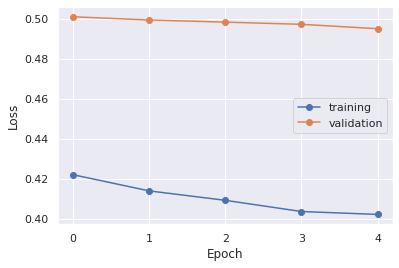

In [58]:
monitor=[
    keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,verbose=1),
    keras.callbacks.ModelCheckpoint('best-model-0.h5',monitor='val_loss',save_best_only=True,save_weights_only=True)
]
history = model.fit(X_train,y_train,
         validation_data=(X_val,y_val),
         epochs=5,
         callbacks=monitor,
         batch_size=128)
history = pd.DataFrame(history.history)
plot_history(history)

Models validation loss and training loss are both going down. This indicates that the model is not overfitting. 

#**Error Analysis**

I tried building a confusion matrix but it wasn't working. 

In [0]:
test_encoded = t.texts_to_matrix(test_data['ingredients'], mode = 'binary')

In [54]:
model.load_weights('best-model-0.h5')
predicted = model.predict(test_encoded).argmax(axis=1)
predicted_df = pd.DataFrame(predicted)
display(predicted_df)
#display(test_data)
results = []
for i in predicted:
  for k,v in index.items():
    if v==i:
      results.append(k)
#print(results)
test_list_id = (test_data['id'])
result = pd.DataFrame(list(zip(test_data['id'], results)),columns=['id','cuisine'])
result_id_df = (result['id'])


,0
0,9
1,1
2,6
3,12
4,6
...,...
9939,14
9940,1
9941,6
9942,1


Text(0.5, 0, 'Predicted label')

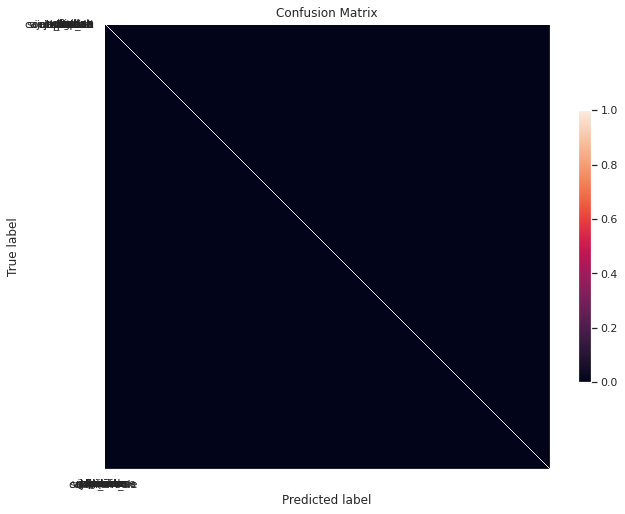

In [59]:
confusionMatrix = confusion_matrix(test_list_id, result_id_df)
plt.figure(figsize=(10,10))
matrix_normilized = (confusionMatrix.astype('float'))/(confusionMatrix.sum(axis=1)[:, np.newaxis])
plt.imshow(matrix_normilized, interpolation='nearest')
plt.title("Confusion Matrix")
plt.colorbar(shrink=.5)
cuisine_plt = train_data['cuisine'].value_counts().index
tick_marks = np.arange(len(cuisine_plt))
plt.xticks(tick_marks, cuisine_plt)
plt.yticks(tick_marks, cuisine_plt)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [22]:
result = pd.DataFrame(list(zip(test_data['id'], results)),columns=['id','cuisine'])
display(result)
#result.to_csv('binaryresults.csv',index=False)
#files.download('binaryresults.csv')

,id,cuisine
0,18009,southern_us
1,28583,southern_us
2,41580,italian
3,29752,cajun_creole
4,35687,italian
...,...,...
9939,30246,southern_us
9940,36028,southern_us
9941,22339,italian
9942,42525,cajun_creole


#**Conclusion**

In conclusion, Kaggle is giving me a score of .74869 which is much better than my baseline of .19267. Overall I think my model was successful. If I had more time I would probably convert it to a learned embeddings model. I would also fix the confusion matrix so I can do better error analysis. 